# This is the python notebook to train various ML models for ai face image identification task. The first step is to download the dataset using the script below.

## 1. Initialization

In [1]:
!pip install kaggle


In [2]:
import os, requests, tarfile, kaggle, zipfile; 


In [3]:
datasets = {
    "ai_faces": "chelove4draste/5k-ai-generated-faces",
    "real_faces": "atulanandjha/lfwpeople"
}

# Local download paths
download_dir = "./datasets"
os.makedirs(download_dir, exist_ok=True)


In [4]:
# Function to download and unzip Kaggle datasets
def download_and_extract(dataset_name, kaggle_path, target_dir):
    print(f"Downloading {dataset_name}...")
    kaggle.api.dataset_download_files(kaggle_path, path=target_dir, unzip=True)
    print(f"{dataset_name} downloaded and extracted to {target_dir}")
# Function to check if a dataset is already downloaded
def is_dataset_downloaded(target_dir):
    # Check if the directory exists and contains files
    return os.path.exists(target_dir) and any(os.scandir(target_dir))



In [5]:
# Download and extract datasets if not already downloaded
for name, kaggle_path in datasets.items():
    dataset_path = os.path.join(download_dir, name)
    os.makedirs(dataset_path, exist_ok=True)
    
    if is_dataset_downloaded(dataset_path):
        print(f"{name} dataset is already downloaded at {dataset_path}.")
    else:
        download_and_extract(name, kaggle_path, dataset_path)

print("Datasets are checked, downloaded, and organized.")


ai_faces dataset is already downloaded at ./datasets/ai_faces.
real_faces dataset is already downloaded at ./datasets/real_faces.
Datasets are checked, downloaded, and organized.


In [6]:
lfw_tgz_path = os.path.join(download_dir, "real_faces", "lfw-funneled.tgz")
extract_path = os.path.join(download_dir, "real_faces")

# Function to extract .tgz files
def extract_tgz(file_path, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=target_dir)
    print(f"Extracted {file_path} to {target_dir}")

# Extract the LFW dataset
extract_tgz(lfw_tgz_path, extract_path)

Extracted ./datasets/real_faces/lfw-funneled.tgz to ./datasets/real_faces


Now, all the initial datasets are downloaded. We will load 4000 of each of the dataset and then randomly pick 2500 of each to be the trainingset, and 750 of each to be validation set, and the rest to be test set.

In [7]:
ai_faces_dir = "./datasets/ai_faces/5k"
real_faces_dir = "./datasets/real_faces/lfw_funneled"

# Function to list files in a directory
def list_files(directory):
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return []
    print(f"Listing files in directory: {directory}")
    files = []
    for root, _, filenames in os.walk(directory):  # Walk through the directory
        for file in filenames:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Filter for image files
                files.append(os.path.join(root, file))
    return files

# List files in AI faces directory
ai_faces_files = list_files(ai_faces_dir)
print(f"Found {len(ai_faces_files)} files in AI faces directory.")
print(f"First 5 files: {ai_faces_files[:5]}")

# List files in Real faces directory
real_faces_files = list_files(real_faces_dir)
print(f"Found {len(real_faces_files)} files in Real faces directory.")
print(f"First 5 files: {real_faces_files[:5]}")


Listing files in directory: ./datasets/ai_faces/5k
Found 5000 files in AI faces directory.
First 5 files: ['./datasets/ai_faces/5k/seed303843.png', './datasets/ai_faces/5k/seed302585.png', './datasets/ai_faces/5k/seed300392.png', './datasets/ai_faces/5k/seed301932.png', './datasets/ai_faces/5k/seed917028.png']
Listing files in directory: ./datasets/real_faces/lfw_funneled
Found 13233 files in Real faces directory.
First 5 files: ['./datasets/real_faces/lfw_funneled/German_Khan/German_Khan_0001.jpg', './datasets/real_faces/lfw_funneled/Stefano_Gabbana/Stefano_Gabbana_0001.jpg', './datasets/real_faces/lfw_funneled/Dragan_Covic/Dragan_Covic_0001.jpg', './datasets/real_faces/lfw_funneled/Jeff_Hornacek/Jeff_Hornacek_0001.jpg', './datasets/real_faces/lfw_funneled/Sureyya_Ayhan/Sureyya_Ayhan_0001.jpg']


In [ ]:
!pip install numpy 
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install seaborn
!pip install matplotlib
from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
import numpy.random as r 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
# Function to load and preprocess images into an array
def load_images_to_array(file_paths, img_size):
    images = []
    for filepath in file_paths:
        try:
            img = Image.open(filepath).convert("RGB")  # Ensure RGB format
            img = img.resize(img_size)  # Resize to target size
            images.append(np.array(img) / 255.0)  # Normalize pixel values
        except Exception as e:
            print(f"Error processing {filepath}: {e}")
    return np.array(images)


In [10]:
# Define constants
IMG_SIZE = (128, 128)  # Resize all images to 128x128
MAX_IMAGES = 2000  # Limit the number of images

# Preprocess AI faces
ai_faces_array = load_images_to_array(ai_faces_files[:MAX_IMAGES], IMG_SIZE)
print(f"AI faces array shape: {ai_faces_array.shape}")

# Preprocess Real faces
real_faces_array = load_images_to_array(real_faces_files[:MAX_IMAGES], IMG_SIZE)
print(f"Real faces array shape: {real_faces_array.shape}")

# Save to numpy arrays
np.save("ai_faces.npy", ai_faces_array)
np.save("real_faces.npy", real_faces_array)

print("Images have been processed and saved to numpy arrays.")

AI faces array shape: (2000, 128, 128, 3)
Real faces array shape: (2000, 128, 128, 3)
Images have been processed and saved to numpy arrays.


In [4]:
# Load the numpy arrays
ai_faces = np.load("ai_faces.npy")
real_faces = np.load("real_faces.npy")

# Define dataset sizes
train_size = 1250
val_size = 400

# Function to split the data randomly
def split_data(data, train_size, val_size):
    indices = np.random.permutation(len(data))  # Shuffle indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    return data[train_indices], data[val_indices], data[test_indices]

# Split AI faces
ai_train, ai_val, ai_test = split_data(ai_faces, train_size, val_size)
print(f"AI Train: {ai_train.shape}, Validation: {ai_val.shape}, Test: {ai_test.shape}")

# Split Real faces
real_train, real_val, real_test = split_data(real_faces, train_size, val_size)
print(f"Real Train: {real_train.shape}, Validation: {real_val.shape}, Test: {real_test.shape}")

# Combine training, validation, and test sets
X_train = np.concatenate((ai_train, real_train), axis=0)
y_train = np.array([0] * len(ai_train) + [1] * len(real_train))  # 0 = AI, 1 = Real

X_val = np.concatenate((ai_val, real_val), axis=0)
y_val = np.array([0] * len(ai_val) + [1] * len(real_val))

X_test = np.concatenate((ai_test, real_test), axis=0)
y_test = np.array([0] * len(ai_test) + [1] * len(real_test))

# Shuffle the datasets for better training
train_indices = np.random.permutation(len(X_train))
val_indices = np.random.permutation(len(X_val))
test_indices = np.random.permutation(len(X_test))

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

# Output the shapes of the final datasets
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation Set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test Set: X_test: {X_test.shape}, y_test: {y_test.shape}")

AI Train: (1250, 128, 128, 3), Validation: (400, 128, 128, 3), Test: (350, 128, 128, 3)
Real Train: (1250, 128, 128, 3), Validation: (400, 128, 128, 3), Test: (350, 128, 128, 3)
Training Set: X_train: (2500, 128, 128, 3), y_train: (2500,)
Validation Set: X_val: (800, 128, 128, 3), y_val: (800,)
Test Set: X_test: (700, 128, 128, 3), y_test: (700,)


## 2. Unsupervised learning

The first step is to perform unsupervised learning analysis on the dataset. Lets start off by plotting some of the datas

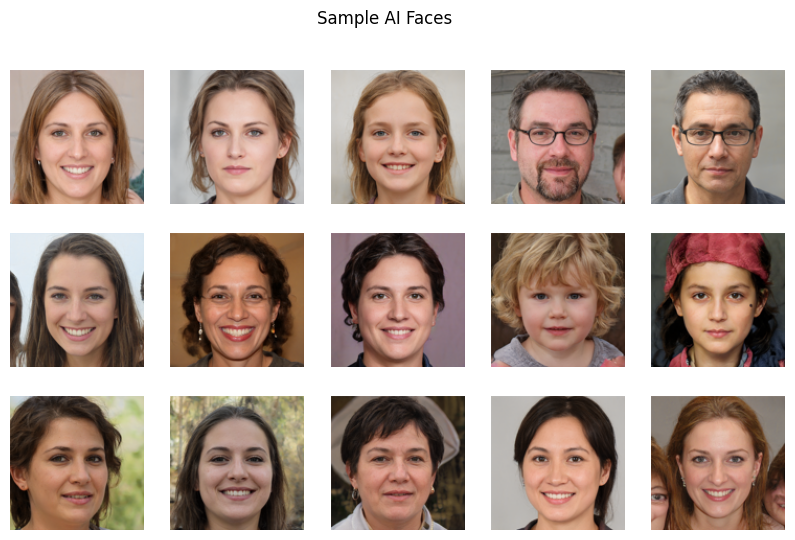

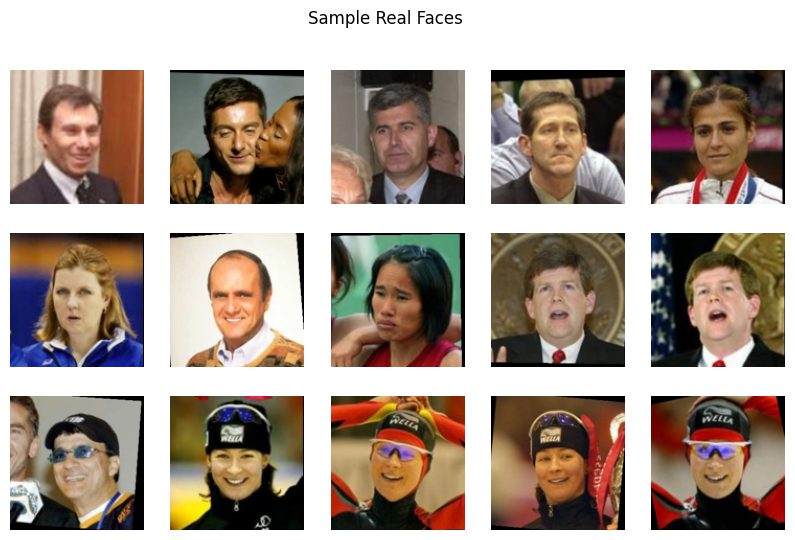

In [ ]:

# Visualize random images
def plot_sample_images(images, title, rows=3, cols=5):
    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot samples
plot_sample_images(ai_faces[:15], "Sample AI Faces")
plot_sample_images(real_faces[:15], "Sample Real Faces")


Compute and plot the mean pixel intensity between the AI faces and real faces dataset

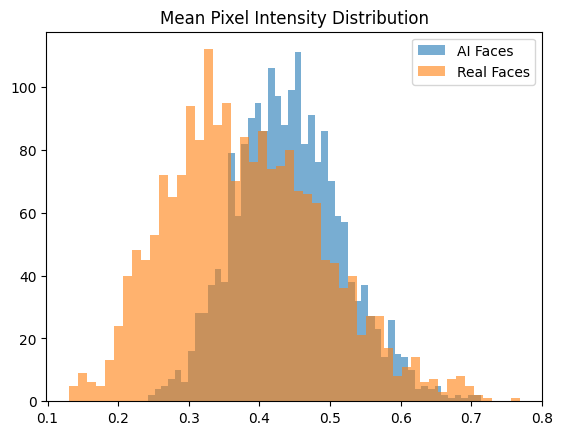

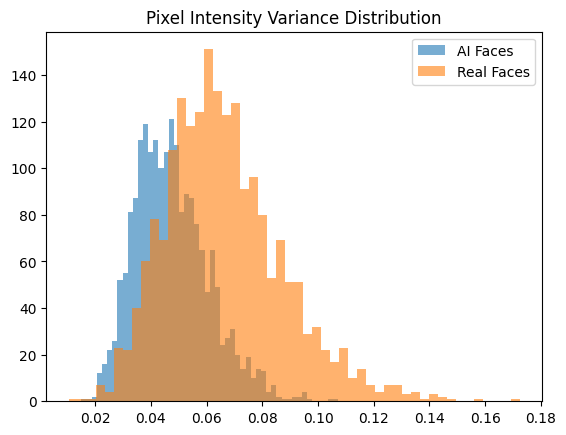

In [ ]:
# Compute mean pixel intensity
ai_mean = ai_faces.mean(axis=(1, 2, 3))
real_mean = real_faces.mean(axis=(1, 2, 3))

plt.hist(ai_mean, bins=50, alpha=0.6, label='AI Faces')
plt.hist(real_mean, bins=50, alpha=0.6, label='Real Faces')
plt.title("Mean Pixel Intensity Distribution")
plt.legend()
plt.show()

# Compute variance of pixel intensities
ai_variance = ai_faces.var(axis=(1, 2, 3))
real_variance = real_faces.var(axis=(1, 2, 3))

# Plot variance distributions
plt.hist(ai_variance, bins=50, alpha=0.6, label='AI Faces')
plt.hist(real_variance, bins=50, alpha=0.6, label='Real Faces')
plt.title("Pixel Intensity Variance Distribution")
plt.legend()
plt.show()



Then try dimension reduction and clustering using PCA

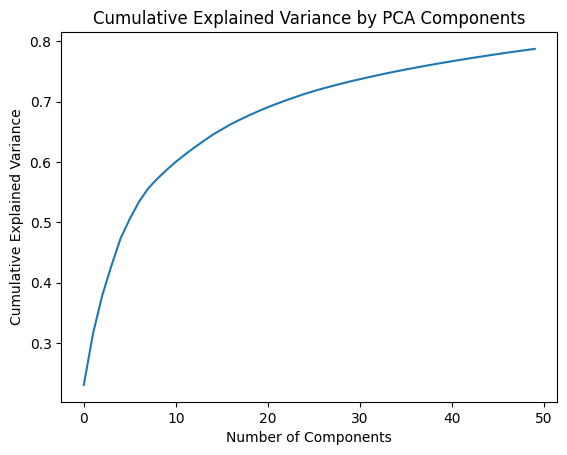

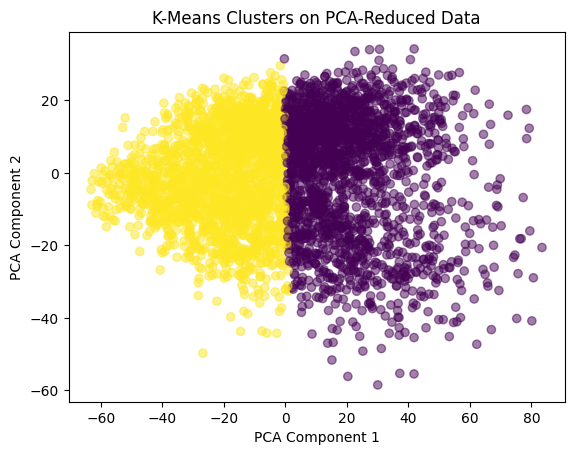

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Flatten images for PCA
X = np.concatenate((ai_faces, real_faces), axis=0)
X_flat = X.reshape(X.shape[0], -1)

# Perform PCA
pca = PCA(n_components=50)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_flat)

# Explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca[:, :2])  # Use first 2 PCA components for visualization

# Visualize clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("K-Means Clusters on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


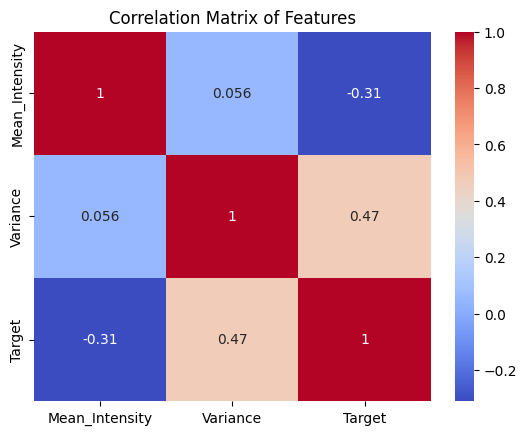

In [ ]:
# Create feature DataFrame
features = pd.DataFrame({
    'Mean_Intensity': np.concatenate([ai_mean, real_mean]),
    'Variance': np.concatenate([ai_variance, real_variance]),
    'Target': [0] * len(ai_mean) + [1] * len(real_mean)  # 0 = AI, 1 = Real
})

# Compute and visualize correlation matrix
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()


### Results from unsupervised learning

From ```Mean Pixel Intensity Distribution```, we can conclude that AI faces have a greater average intensity, while real faces has a wider distribution of intensity.

From ```Pixel Intensity Variance Distribution```, we can conclude that real faces have a wider variance in terms of pixel intensity compared to AI faces.

From ```Cumulative Explained Variance by PCA Components```, we can conclude that 50 features capture close to 80% of the variences. 

From ```K-Means Clusters on PCA-Reduced Data```, we can conclude that the first two PCA components are relatives distinct. 

From ```Correlation Matrix of Features```, we can conclude that both mean intensity and variance are important features to distinguish the datasets. 

## 3. Supervised learning


After the initialization is completed and loaded to np arrays, it is time to start trying various techniques of ML.

#### 3.1 Neuron Networks
The first aspect to try is simple NN, using sigmoid function

In [ ]:
def convert_to_grayscale(images):
    return np.array([rgb2gray(image) for image in images])  # Convert each image to grayscale

In [ ]:
X_train_gray = convert_to_grayscale(X_train)
X_val_gray = convert_to_grayscale(X_val)
X_test_gray = convert_to_grayscale(X_test)

# Reshape the images to 1D arrays (flattened)
X_train_flat = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_val_flat = X_val_gray.reshape(X_val_gray.shape[0], -1)
X_test_flat = X_test_gray.reshape(X_test_gray.shape[0], -1)


In [18]:
def convert_y_to_vect_binary(y):
    y_vect = np.zeros((len(y), 2))  # Binary classification: 2 classes (AI, Real)
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [ ]:
y_v_train = convert_y_to_vect_binary(y_train)
y_v_val = convert_y_to_vect_binary(y_val)
y_v_test = convert_y_to_vect_binary(y_test)


Now the NN intialization is completed, and start NN with sigmoid.

In [20]:
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

# Initialize weights and biases
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

# Initialize gradient storage
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

# Feed forward
def feed_forward(x, W, b):
    a = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        node_in = a[l]
        z[l + 1] = W[l].dot(node_in) + b[l]
        a[l + 1] = f(z[l + 1])
    return a, z

# Backpropagation
def calculate_out_layer_delta(y, a_out, z_out):
    return -(y - a_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)


In [21]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print(f'Starting gradient descent for {iter_num} iterations')
    while cnt < iter_num:
        if cnt % 1000 == 0:
            print(f'Iteration {cnt} of {iter_num}')
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            a, z = feed_forward(X[i, :], W, b)
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i, :], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i, :] - a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l + 1], W[l], z[l])
                    tri_W[l] += np.dot(delta[l + 1][:, np.newaxis], np.transpose(a[l][:, np.newaxis]))
                    tri_b[l] += delta[l + 1]
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0 / N * tri_W[l])
            b[l] += -alpha * (1.0 / N * tri_b[l])
        avg_cost = 1.0 / N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


In [22]:
def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 1000 of 5000
Iteration 2000 of 5000
Iteration 3000 of 5000
Iteration 4000 of 5000


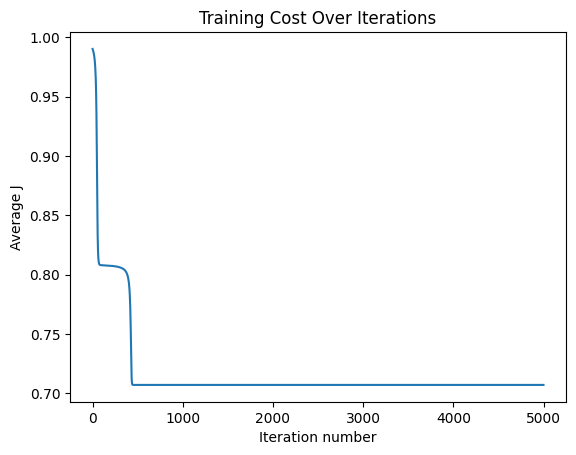

In [29]:
import matplotlib.pyplot as plt
nn_structure = [128 * 128, 10,  2]
W, b, avg_cost_func = train_nn(nn_structure, X_train_flat, y_v_train, iter_num=5000)

# Plot the cost function
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.title('Training Cost Over Iterations')
plt.show()

In [36]:
print(f'Weight is: {W}')
# Evaluate on the test set
y_pred = predict_y(W, b, X_val_flat, len(nn_structure))
y_pred_binary = np.round(y_pred).astype(int)  # Convert predictions to binary

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_binary)
print(f'Prediction accuracy on the test set is {accuracy * 100:.2f}%')

Weight is: {1: array([[0.61047021, 0.55322281, 0.35286906, ..., 0.42517648, 0.39052176,
        0.07907086],
       [0.82743779, 0.21213161, 0.54963619, ..., 0.38133857, 0.78571478,
        0.051709  ],
       [0.87185339, 0.88912724, 0.39568481, ..., 0.71247044, 0.4316795 ,
        0.24092003],
       ...,
       [0.72189791, 0.34687012, 0.07287532, ..., 0.46074502, 0.87302452,
        0.99032921],
       [0.96076437, 0.0152393 , 0.58589867, ..., 0.59885995, 0.01282324,
        0.68922455],
       [0.95303523, 0.08562973, 0.07087396, ..., 0.51156082, 0.57980283,
        0.10630636]]), 2: array([[ 0.1580594 ,  0.24806473,  0.31537791, -0.27287848,  0.08211127,
        -0.20027414,  0.37276984,  0.06080934, -0.22545704, -0.39988748],
       [-0.04867276, -0.25257463,  0.12171724, -0.12853789,  0.22971417,
         0.06919625, -0.22134248,  0.17896071,  0.0092756 ,  0.15625785]])}
Prediction accuracy on the test set is 50.00%


#### 3.2 Logistic regression

The second supervised learning technique to try is logistic regression

In [47]:
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Logistic Regression Model
logreg = linear_model.LogisticRegression(penalty=None)  # No regularization
logreg.fit(X_train_flat, y_train)  # Use flattened grayscale images for training

# Model Coefficients and Intercept
w_logreg = logreg.coef_
intercept_logreg = logreg.intercept_

print(f'Logistic regression weights are: {w_logreg}')
# Predictions
y_hat_logreg = logreg.predict(X_val_flat)  # Predict on test set

# Accuracy on Test Set
acc_logreg = logreg.score(X_val_flat, y_val)

print("Accuracy on test data: %.2f%%" % (acc_logreg * 100))

# Precision, Recall, and F-score
prec, recal, fscore, sup = precision_recall_fscore_support(y_val, y_hat_logreg, average='binary')

print(f"Precision: {prec:.2f}")
print(f"Recall: {recal:.2f}")
print(f"F1-Score: {fscore:.2f}")

# Classification Report for more detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_val, y_hat_logreg, target_names=["AI", "Real"]))



Logistic regression weights are: [[-0.02184942 -0.02002359 -0.01619033 ... -0.00909197 -0.00926915
  -0.00981478]]
Accuracy on test data: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Classification Report:

              precision    recall  f1-score   support

          AI       1.00      1.00      1.00       400
        Real       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



#### 3.3 Support Vector Machines

The last supervised learning technique to try is SVMs


In [15]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import StandardScaler

# Reload the dataset to ensure clean data
# Assume `ai_faces.npy` and `real_faces.npy` are the dataset files
ai_faces = np.load("ai_faces.npy")
real_faces = np.load("real_faces.npy")

# Define dataset sizes
train_size = 1250
val_size = 400

# Function to split the data randomly
def split_data(data, train_size, val_size):
    indices = np.random.permutation(len(data))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    return data[train_indices], data[val_indices], data[test_indices]

# Split AI and Real faces into train/validation/test sets
ai_train, ai_val, ai_test = split_data(ai_faces, train_size, val_size)
real_train, real_val, real_test = split_data(real_faces, train_size, val_size)

# Combine datasets and labels
X_train = np.concatenate((ai_train, real_train), axis=0)
X_val = np.concatenate((ai_val, real_val), axis=0)
X_test = np.concatenate((ai_test, real_test), axis=0)

y_train = np.array([0] * len(ai_train) + [1] * len(real_train))
y_val = np.array([0] * len(ai_val) + [1] * len(real_val))
y_test = np.array([0] * len(ai_test) + [1] * len(real_test))

# Flatten images and normalize features
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Convert labels to -1 and +1 for SVM
y_train_svm = np.where(y_train == 0, -1, 1)
y_val_svm = np.where(y_val == 0, -1, 1)
y_test_svm = np.where(y_test == 0, -1, 1)

# Define the SVM objective function
def svm_objective(w, X, y, lambda1=0.1):
    """
    Calculate the SVM objective function.
    
    w: weights
    X: input data
    y: labels (-1 or +1 for SVM)
    lambda1: regularization parameter
    """
    regularization_term = (lambda1 / 2) * np.linalg.norm(w)**2
    hinge_loss = np.maximum(0, 1 - y * (np.dot(X, w)))
    result = regularization_term + hinge_loss.sum()
    return result

# SVM Training
def train_svm(X, y, lambda1=0.1):
    """
    Train an SVM using the objective function.
    
    X: input data (N x d)
    y: labels (-1 or +1 for SVM)
    lambda1: regularization parameter
    """
    N, d = X.shape
    w0 = np.zeros(d)  # Initialize weights to zeros
    
    # Use scipy.optimize.minimize to minimize the objective function
    result = minimize(fun=svm_objective, x0=w0, args=(X, y, lambda1), method='L-BFGS-B')
    return result.x  # Optimized weights

# Train the SVM with the training set and evaluate using the validation set
lambda1 = 0.1  # Regularization parameter
w_svm = train_svm(X_train_scaled, y_train_svm, lambda1=lambda1)

# Make predictions on the validation set
y_val_pred_svm = np.sign(np.dot(X_val_scaled, w_svm))

# Evaluate the SVM on the validation set
val_accuracy = accuracy_score(y_val_svm, y_val_pred_svm)
val_prec, val_recal, val_fscore, val_sup = precision_recall_fscore_support(y_val_svm, y_val_pred_svm, average='binary')

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_prec:.2f}")
print(f"Validation Recall: {val_recal:.2f}")
print(f"Validation F1-Score: {val_fscore:.2f}")

# Classification report on the validation set
print("\nValidation Classification Report:\n")
print(classification_report(y_val_svm, y_val_pred_svm, target_names=["AI", "Real"]))


KeyboardInterrupt: 

## 5. Model testing

For fun, lets test the models using the picture of NYU's president Linda G. Mills

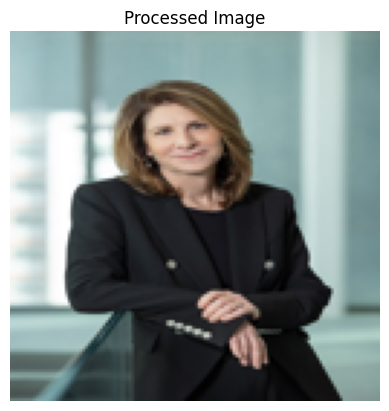

The predicted label for the sample image is: Real


In [ ]:
# Function to load and preprocess a single image
def preprocess_single_image(filepath, img_size):
    """
    Preprocess a single image: resize, normalize, and convert to numpy array.
    
    filepath: Path to the image file.
    img_size: Target size (width, height) for resizing the image.
    
    Returns: Preprocessed image as a numpy array.
    """
    try:
        img = Image.open(filepath).convert("RGB")  # Ensure RGB format
        img = img.resize(img_size)  # Resize to target size
        plt.imshow(img)
        plt.title("Processed Image")
        plt.axis("off")
        plt.show()
        return np.array(img) / 255.0  # Normalize pixel values
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Preprocess the sample image
SAMPLE_IMG_SIZE = (128, 128)  # Target size for resizing
sample_image_path = "image.png"  # Update to your sample image path

sample_image_processed = preprocess_single_image(sample_image_path, SAMPLE_IMG_SIZE)

# Check the shape of the processed image and proceed to scaling if successful
if sample_image_processed is not None:
    # Flatten the image to match the input of the model
    sample_image_flat = sample_image_processed.reshape(1, -1)

    # Scale the sample image using the trained StandardScaler
    sample_image_scaled = scaler.transform(sample_image_flat)

    # Use the trained SVM model to predict the label for the sample image
    sample_image_pred = np.sign(np.dot(sample_image_scaled, w_svm))

    # Map prediction to label
    predicted_label = "AI-Generated" if sample_image_pred[0] == -1 else "Real"

    # Display the result
    print(f"The predicted label for the sample image using SVM is: {predicted_label}")

else:
    "Failed to preprocess the sample image."
